<a href="https://colab.research.google.com/github/davidschep/NewsComparison/blob/main/WebscrapingNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import pytz
import seaborn as sns

# V2 - Scrape Articles from Top News Page

In [225]:
class Top_News:
  def __init__(self, publication_names):
    self.publication_names = publication_names if publication_names != 'all' else ['NY Post', 'Atlantic', 'CNN', 'Business Insider', 'Washington Post', 'Fox News', 'Guardian']
    self.results_df = pd.DataFrame()
    self.scrapers = {
        'NY Post': scrape_ny_post_article,
        'Atlantic': scrape_atlantic_article,
        'CNN': scrape_cnn_article,
        'Business Insider': scrape_business_insider_article,
        'Washington Post': scrape_washington_post_article,
        'Fox News': scrape_fox_news_article,
        'Guardian': scrape_guardian_article
    }
    self.class_data = {
        'NY Post': ['https://nypost.com/', 'story__headline headline headline--xl', 'story__headline headline headline--sm', 'story__headline headline headline--combo-lg-xl headline--with-inline-webwood'],
        'Atlantic': ['https://www.theatlantic.com/world/', 'HomepageBottom_channelArticle__2wxRe', 'SmallPromoItem_root__nkm_2', 'Lede_title__7Wg1g', 'Offlede_title__kiinC', 'QuadBelt_title__mB6Zf', 'DoubleWide_title__diUPi', 'DoubleStack_title___FhPb', 'Latest_article__DW75m', 'Popular_listItem__CtMMj'],
        'CNN': ['https://edition.cnn.com/', 'container__link', 'container__title container_lead-package__title container__title--emphatic hover container__title--emphatic-size-l1'],
        'Business Insider': ['https://www.businessinsider.com/', 'tout', 'quick-link', 'most-popular-item', '.featured-tout-collection-wrapper .tout-title a', '.two-column-wrapper .tout-title-link'],
        'Washington Post': ['https://www.washingtonpost.com/', 'wpds-c-iiQaMf wpds-c-iiQaMf-igUpeQR-css', 'wpds-c-iiQaMf wpds-c-iiQaMf-ikZTsyd-css', 'wpds-c-iiQaMf wpds-c-iiQaMf-ibYgSwf-css'],
        'Fox News': ['https://www.foxnews.com/', 'article'],
        'NY Times': ['https://www.nytimes.com/', 'css-9mylee'],
        'Guardian': ['https://www.theguardian.com/', 'dcr-12ilguo', 'dcr-yw3hn9']
    }

  def _get_soup(self, url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # This will raise an HTTPError if the HTTP request returned an unsuccessful status code
        return BeautifulSoup(response.text, 'html.parser')
    except requests.exceptions.RequestException as e:
        print(f"Request failed for {url}: {e}")
        return None

  def scrape_publications(self):

    selected_class_data = {name: self.class_data[name] for name in self.publication_names if name in self.class_data}
    articles_data = []

    for class_name in selected_class_data:
        base_url = selected_class_data[class_name][0]
        response = requests.get(base_url)
        soup = BeautifulSoup(response.text, 'html.parser')

        article_blocks = []
        for c_ in selected_class_data[class_name][1:]:
            temp = soup.find_all(class_=c_) if (class_name != 'Fox News') else soup.find_all('article')
            temp = temp if temp else soup.select(c_)
            article_blocks.extend(temp)

        for block in article_blocks:
            url = block.find('a')['href'] if block.find('a') else (block['href'] if 'href' in block.attrs else None)
            if url:
                article_data = {
                    'name': class_name,
                    'title': block.get_text(strip=True),
                    'url': base_url[:-1]+url if url.startswith('/') else url
                }
                articles_data.append(article_data)

    self.results_df = pd.DataFrame(articles_data)
    self.results_df.drop_duplicates(subset=['url'], inplace=True)
    self.results_df.reset_index(drop=True, inplace=True)

    return self.results_df

  def article_distribution(self):
    if not self.results_df.empty:
      self.results_df.groupby('name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
      plt.gca().spines[['top', 'right',]].set_visible(False)
      plt.show()
    else:
      print('Scrape publications first')

  def scrape_articles(self, max_articles_per_publication=None):
    if self.results_df.empty:
        print("Scraping publications for article URLs...")
        self.scrape_publications()

    all_article_data = []
    articles_count = {}

    for index, row in self.results_df.iterrows():
        publication_name = row['name']
        if publication_name in self.scrapers:
            articles_count.setdefault(publication_name, 0)
            if max_articles_per_publication is None or articles_count[publication_name] < max_articles_per_publication:
                try:
                    article_data = self.scrapers[publication_name](row)
                    all_article_data.append(article_data)
                    articles_count[publication_name] += 1
                except Exception as e:
                    print(f"An error occurred while scraping {row['url']}: {e}")

    self.results_df = pd.DataFrame(all_article_data)
    self.results_df.drop_duplicates(subset=['url'], inplace=True)
    self.results_df.reset_index(drop=True, inplace=True)




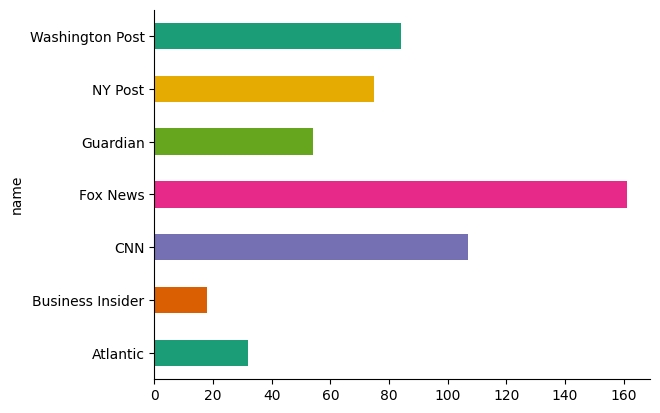

In [226]:
if __name__ == "__main__":
    news_scraper = Top_News('all')
    news_scraper.scrape_publications()
    news_scraper.article_distribution()
    news_scraper.results_df.head()

In [227]:
news_scraper.scrape_articles()
news_scraper.results_df

,name,title,url,summary,author,content,date
0,NY Post,Jets blown out by Buffalo as Zach Wilson quest...,https://nypost.com/2023/11/19/sports/jets-blow...,None,Brian Costello,Δ Thanks for contacting us. We've received you...,"Nov. 19, 2023, 7:53 p.m. ET"
1,Atlantic,Another ‘Rapid Unscheduled Disassembly’ for El...,https://www.theatlantic.com/science/archive/20...,"SpaceX’s Starship blew up again, and NASA’s mo...",Marina Koren,"The second liftoff of Starship, SpaceX’s giant...",2023-11-18T14:04:17Z
2,CNN,Israel-Hamas war,https://edition.cnn.com/2023/11/19/politics/ha...,None,MJ Lee,A recent draft of a possible deal to secure th...,"5:17 PM EST, Sun November 19, 2023"
3,Business Insider,"PoliticsRosalynn Carter, former first lady of ...",https://www.businessinsider.com/rosalynn-carte...,"GOP has 'systematically followed' the facts, M...",Sebastian Cahill,"Rosalynn Carter, the former first lady ...",2023-11-19T20:20:10Z
4,Washington Post,"Rosalynn Carter, first lady who championed men...",https://www.washingtonpost.com/obituaries/2023...,,Kevin Sullivan and Kevin Sullivan,"Rosalynn Carter, a close political and policy ...","November 19, 2023 at 3:18 p.m. EST"
5,Fox News,CLOSING INKevin McCarthy makes stunning admiss...,https://www.foxnews.com/media/mccarthy-stunnin...,"GOP has 'systematically followed' the facts, M...",Kayla Bailey,Former House Speaker Kevin McCarthy joins ‘Sun...,"November 19, 2023 2:00pm EST"
6,Guardian,Rosalynn CarterWife of Jimmy Carter and former...,https://www.theguardian.com/us-news/2023/nov/1...,"Carter, who was diagnosed with dementia in May...",Richard Luscombe,"Rosalynn Carter, wife of the 39th presidentJim...",Sun 19 Nov 2023 18.24 EST


## Scrape Guardian

In [223]:
def scrape_guardian_article(df_row):
    # Send a request to the URL and parse the content
    response = requests.get(df_row['url'])
    soup = BeautifulSoup(response.text, 'html.parser')

    # Attempt to get summary
    summary_tag = soup.find('div', {'data-gu-name': 'standfirst'})
    summary = summary_tag.get_text(strip=True) if summary_tag else None

    # Attempt to get author
    author_tag = soup.find('a', rel='author')
    author = author_tag.get_text(strip=True) if author_tag else 'Unknown'

    # Attempt to get content
    content_tags = soup.find_all('p')
    content = ' '.join(tag.get_text(strip=True) for tag in content_tags[1:])

    # Attempt to get date
    date_tag = soup.find('span', class_='dcr-u0h1qy')
    date_string = date_tag.get_text(strip=True) if date_tag else 'Unknown'

    """
    # Parse the date if it's not 'Unknown'
    if date_string != 'Unknown':
        try:
            date_format = "%B %d, %Y %I:%M%p"
            date = datetime.strptime(date_string, date_format)
        except ValueError:
            date = 'Unknown'
    else:
        date = 'Unknown'

    """

    # Update the df_row with the scraped data
    df_row['summary'] = summary
    df_row['author'] = author
    df_row['content'] = content
    #df_row['date'] = date
    df_row['date'] = date_string

    return df_row

In [224]:
#trial = results_df[results_df['name'] == 'Guardian'][:5].apply(lambda df_row: scrape_guardian_article(df_row), axis=1)
#trial

,name,title,url,summary,author,content,date
514,Guardian,Rosalynn CarterWife of Jimmy Carter and former...,https://www.theguardian.com/us-news/2023/nov/1...,"Carter, who was diagnosed with dementia in May...",Richard Luscombe,"Rosalynn Carter, wife of the 39th presidentJim...",Sun 19 Nov 2023 18.24 EST
515,Guardian,OpenAIOusted CEO Sam Altman ‘in talks to retur...,https://www.theguardian.com/technology/2023/no...,Boss was sacked by ChatGPT developer over fail...,Dan Milmo,Sam Altman is being lined up for a surprise re...,Sun 19 Nov 2023 17.16 EST
516,Guardian,Donald TrumpIllinois governor ‘deeply concerne...,https://www.theguardian.com/us-news/2023/nov/1...,"JB Pritzker, who’s of Jewish descent, says Tru...",Richard Luscombe,"Donald Trump’s rhetoric on immigration, his pl...",Sun 19 Nov 2023 14.50 EST
517,Guardian,Musk ‘believes in America’DeSantis defends X o...,https://www.theguardian.com/us-news/2023/nov/1...,Florida governor claims he hasn’t seen the mes...,Richard Luscombe,Ron DeSantis defended Elon Musk as “a guy that...,Sun 19 Nov 2023 12.03 EST
518,Guardian,CaliforniaMale nanny gets 707 years in prison ...,https://www.theguardian.com/us-news/2023/nov/1...,Matthew Antonio Zakrzewski was arrested in 201...,Unknown,A male nanny who advertised himself as a “mann...,Unknown


## Scrape Washington Post

In [178]:
def scrape_washington_post_article(df_row):
    response = requests.get(df_row['url'])
    soup = BeautifulSoup(response.text, 'html.parser')

    # Attempt to get summary
    summary = None
    summary_candidates = ['PJLV PJLV-iPJLV-css grid-center w-100']
    for candidate in summary_candidates:
        summary_tag = soup.find(class_=candidate)
        if summary_tag:
            summary = summary_tag.get_text(strip=True)
            break

    # Attempt to get author
    author = None
    author_candidates = ['wpds-c-cNdzuP wpds-c-cNdzuP-ejzZdU-isLink-true', 'a[data-qa="author-name"]']
    authors = []
    for candidate in author_candidates:
        author_tags = soup.find_all(class_=candidate) or soup.find_all('a', {'data-qa': 'author-name'})
        for tag in author_tags:
            authors.append(tag.get_text(strip=True))
    author = ' and '.join(authors)

    # Get content
    content_list = soup.find_all(class_='article-body grid-center grid-body') or soup.find_all('p')
    content = ' '.join(content.get_text(strip=True) for content in content_list)

    # Get date
    date_string = None
    date_candidates = ['wpds-c-iKQyrV', 'wpds-c-iKQyrV wpds-c-iKQyrV-ihqANPJ-css overrideStyles']
    for candidate in date_candidates:
        date_tag = soup.find(class_=candidate)
        if date_tag:
            date_string = date_tag.get_text(strip=True)
            #date_string = date_string.replace('.m.', 'm').replace('EST', '').strip()
            break

    # Parse the date
    #date_format = "%B %d, %Y at %I:%M %p"
    #date = datetime.strptime(date_string, date_format) if date_string else None

    df_row['summary'] = summary
    df_row['author'] = author
    df_row['content'] = content
    #df_row['date'] = date
    df_row['date'] = date_string

    return df_row

In [179]:
#trial = results_df[results_df['name'] == 'Washington Post'][:5].apply(lambda df_row: scrape_washington_post_article(df_row), axis=1)
#trial

,name,title,url,summary,author,content,date
235,Washington Post,"Rosalynn Carter, first lady who championed men...",https://www.washingtonpost.com/obituaries/2023...,,Kevin Sullivan and Kevin Sullivan,"Rosalynn Carter, a close political and policy ...","November 19, 2023 at 3:18 p.m. EST"
236,Washington Post,Antisemitism was rising online. Then Elon Musk...,https://www.washingtonpost.com/technology/2023...,None,Elizabeth Dwoskin and Taylor Lorenz and Naomi ...,In the weeks following the Oct. 7Hamasattack o...,"November 19, 2023 at 12:00 p.m. EST"
237,Washington Post,A midnight trip into northern Gaza reveals tot...,https://www.washingtonpost.com/world/2023/11/1...,None,Steve Hendrix and Steve Hendrix,GAZA CITY — To enter Gaza now is to arrive in ...,"November 19, 2023 at 1:11 p.m. EST"
238,Washington Post,F1’s sloppy Las Vegas weekend,https://www.washingtonpost.com/sports/2023/11/...,Auto Racing,Roman Stubbs and Roman Stubbs,LAS VEGAS — They had flown to Nevada from all ...,"November 19, 2023 at 7:02 a.m. EST"
239,Washington Post,"From airlines to ticket sellers, companies fig...",https://www.washingtonpost.com/business/2023/1...,Economic Policy,Tony Romm and Tony Romm,Frustrated with airlines that charge passenger...,"November 19, 2023 at 6:00 a.m. EST"


## Scrape NY *Post*

In [180]:
def scrape_ny_post_article(df_row):
    response = requests.get(df_row['url'])
    soup = BeautifulSoup(response.text, 'html.parser')

    # No summaries exist
    summary = None

    # Get author
    author_tag = soup.find('span', class_='meta__link')
    author = author_tag.get_text(strip=True)[16:] if author_tag else 'Unknown'

    # Get content
    content_list = soup.find_all('p')[1:-1]
    content = ' '.join(content.get_text(strip=True) for content in content_list)

    # Get date
    date_tag = soup.find('div', class_='date--updated__item')
    date_string = date_tag.find_all('span')[1].get_text(strip=True) if date_tag else 'Unknown'
    #date_string = date_string.replace('.m.', 'M').replace('ET', '').strip()
    #date_format = "%b. %d, %Y, %I:%M %p"
    #try:
        #date = datetime.strptime(date_string, date_format)
    #except ValueError:
        #date = 'Unknown'

    df_row['summary'] = summary
    df_row['author'] = author
    df_row['content'] = content
    #df_row['date'] = date
    df_row['date'] = date_string

    return df_row

In [181]:
#trial = results_df[results_df['name'] == 'NY Post'][:5].apply(lambda df_row: scrape_ny_post_article(df_row), axis=1)
#trial

,name,title,url,summary,author,content,date
0,NY Post,Rookie QB goes off as Giants dominate Commande...,https://nypost.com/2023/11/19/sports/giants-to...,None,Paul Schwartz,Δ Thanks for contacting us. We've received you...,"Nov. 19, 2023, 4:23 p.m. ET"
1,NY Post,"NY ranked 'Least Free State,' with high taxes,...",https://nypost.com/2023/11/19/metro/ny-ranked-...,None,Carl Campanile,Δ Thanks for contacting us. We've received you...,"Nov. 19, 2023, 5:16 p.m. ET"
2,NY Post,Cops believe torso found on NYC beach may be v...,https://nypost.com/2023/11/19/metro/torso-foun...,None,Joe Marino,Police believe the human torso found on a Quee...,"Nov. 19, 2023, 2:47 p.m. ET"
3,NY Post,Star offensive lineman carted off in potential...,https://nypost.com/2023/11/19/sports/mekhi-bec...,None,Andrew Crane,The Jets have dealt with plenty of offensive l...,"Nov. 19, 2023, 5:21 p.m. ET"
4,NY Post,Brigitte Macron says her 'head was in a mess' ...,https://nypost.com/2023/11/19/news/brigitte-ma...,None,Unknown,French President Emmanuel Macron’s wife Brigit...,"Nov. 19, 2023, 1:25 p.m. ET"


## Scrape Atlantic

In [182]:
def scrape_atlantic_article(df_row):
    # Send a request to the URL and parse the content
    response = requests.get(df_row['url'])
    soup = BeautifulSoup(response.text, 'html.parser')

    # Attempt to get summary
    summary_tag = soup.find(class_='ArticleHero_dek__EqdkK')
    summary = summary_tag.get_text(strip=True) if summary_tag else None

    # Attempt to get author
    author_tag = soup.find(class_='ArticleBylines_link__kNP4C')
    author = author_tag.get_text(strip=True) if author_tag else 'Unknown'

    # Attempt to get content
    content_tags = soup.find_all('p', class_='ArticleParagraph_root__4mszW')
    content = ' '.join(tag.get_text(strip=True) for tag in content_tags)

    # Attempt to get date
    date_tag = soup.find('time', class_='ArticleTimestamp_root__b3bL6')
    date = date_tag['datetime'] if date_tag else 'Unknown'

    # Parse the date if it's not 'Unknown'
    #if date != 'Unknown':
        #try:
            #date = datetime.strptime(date, '%Y-%m-%dT%H:%M:%SZ').isoformat()
        #except ValueError:
            #date = 'Unknown'

    # Update the df_row with the scraped data
    df_row['summary'] = summary
    df_row['author'] = author
    df_row['content'] = content
    df_row['date'] = date

    return df_row

In [183]:
#trial = results_df[results_df['name'] == 'Atlantic'][:5].apply(lambda df_row: scrape_atlantic_article(df_row), axis=1)
#trial

,name,title,url,summary,author,content,date
75,Atlantic,Another ‘Rapid Unscheduled Disassembly’ for El...,https://www.theatlantic.com/science/archive/20...,"SpaceX’s Starship blew up again, and NASA’s mo...",Marina Koren,"The second liftoff of Starship, SpaceX’s giant...",2023-11-18T14:04:17Z
76,Atlantic,The Women Who Saw 9/11 ComingLiza Mundy,https://www.theatlantic.com/ideas/archive/2023...,Many of the CIA analysts who spotted the earli...,Liza Mundy,"One day toward the end of the 20th century, Jo...",2023-11-18T12:00:00Z
77,Atlantic,The UFO Cover-Up Is Real—But It’s Not What You...,https://www.theatlantic.com/ideas/archive/2023...,"Decades of declassified memos, internal report...",Garrett M. Graff,There aren’t many secrets that John Brennan do...,2023-11-17T14:40:00Z
78,Atlantic,It’s Not That Hard to Stop Birds from Crashing...,https://www.theatlantic.com/science/archive/20...,Chicago’s glass skyscrapers are a menace for b...,Ben Goldfarb,This article originally appeared in longer for...,2023-11-18T13:00:00Z
79,Atlantic,Revisiting Hidden Pasts at the National Book A...,https://www.theatlantic.com/newsletters/archiv...,"This year, the awards honored books that resur...",Gal Beckerman,"The National Book Awards, a glitzy affair othe...",2023-11-17T17:20:00Z


## Scrape CNN

In [228]:
def scrape_cnn_article(df_row):
    response = requests.get(df_row['url'])
    soup = BeautifulSoup(response.text, 'html.parser')

    # No summaries for CNN articles
    summary = None

    # Check if it's a live news article and get the author, content, and date accordingly
    if '/live-news/' in df_row['url']:
        author_tag = soup.find('p', {'data-type': 'byline-area'})
        author = author_tag.get_text(strip=True) if author_tag else 'Unknown'

        content_tags = soup.find_all('p', class_='sc-gZMcBi render-stellar-contentstyles__Paragraph-sc-9v7nwy-2 dCwndB')
        content = ' '.join(tag.get_text(strip=True) for tag in content_tags)

        date_tag = soup.find('div', class_='hJIoKL')
        date = date_tag.get_text(strip=True) if date_tag else 'Unknown'
        date_string = ' '.join(date.split(' ')[-3:])+' '+str(date.split(' ')[2][1:3])+':'+(date.split(' ')[2][3:5]) if date!='Unknown' else 'Unknown'
    else:
        author_tag = soup.find(class_='byline__link')
        author = author_tag.get_text(strip=True) if author_tag else 'Unknown'

        content_tags = soup.find_all('p', class_='paragraph inline-placeholder')
        content = ' '.join(tag.get_text(strip=True) for tag in content_tags)

        date_tag = soup.find(class_='timestamp')
        #date_string = ' '.join(date_tag.get_text(strip=True).split(' ')[-7:][-3:]+date_tag.get_text(strip=True).split(' ')[-7:][0:2]) if date_tag else 'Unknown'
        date_string = date_tag.get_text(strip=True).split('\n')[-1] if date_tag else 'Unknown'

    # Parse the date if it's not 'Unknown'
    """
    if date_string != 'Unknown':
        try:
            if '/live-news/' in df_row['url']:
                date_format = "%B %d, %Y %H:%M"
            else:
                date_format = '%B %d, %Y %I:%M %p'
            date = datetime.strptime(date_string, date_format).isoformat()
        except ValueError:
            date = 'Unknown'
    """

    # Update the df_row with the scraped data
    df_row['summary'] = summary
    df_row['author'] = author
    df_row['content'] = content
    #df_row['date'] = date
    df_row['date'] = date_string

    return df_row

In [188]:
#trial = results_df[results_df['name'] == 'CNN'][:5].apply(lambda df_row: scrape_cnn_article(df_row), axis=1)
#trial

,name,title,url,summary,author,content,date
105,CNN,Israel-Hamas war,https://edition.cnn.com/middleeast/live-news/i...,None,"By Chris Lau,Andrew Raine,Lauren Said-Moorhous...",Our live coverage of the Israel-Hamas war has...,"November 19, 2023 13:10"
106,CNN,SpaceX launch,https://edition.cnn.com/world/live-news/spacex...,None,"ByJackie Wattles, CNN",Our live coverage has wrapped up for the day.R...,"November 18, 2023 03:49"
107,CNN,Trump’s insurrection,https://edition.cnn.com/2023/11/17/politics/tr...,None,Marshall Cohen,A Colorado judge has ruled that former Preside...,"10:35 PM EST, Fri November 17, 2023"
108,CNN,Latest from Ukraine,https://edition.cnn.com/2023/11/18/world/dwind...,None,Unknown,Ukraine this weekclaimedto have “gained a foot...,"6:56 AM EST, Sun November 19, 2023"
109,CNN,Renewed fighting in Myanmar,https://edition.cnn.com/2023/11/18/asia/myanma...,None,Unknown,Renewed fighting between the Myanmar Armed For...,"3:16 AM EST, Sat November 18, 2023"


## Scrape Business Insider

In [121]:
def scrape_business_insider_article(df_row):
    # Send a request to the URL and parse the content
    response = requests.get(df_row['url'])
    soup = BeautifulSoup(response.text, 'html.parser')

    summary = None

    # Attempt to get author
    author_tag = soup.find(class_='byline-author headline-bold')
    author = author_tag.get_text(strip=True) if author_tag else 'Unknown'

    # Attempt to get content
    content_tags = soup.find_all('p')
    content = ' '.join(tag.get_text(strip=True) for tag in content_tags[1:])

    # Attempt to get date
    date_tag = soup.find('div', class_='byline-timestamp')
    date = date_tag['data-timestamp'] if date_tag else 'Unknown'

    # Update the df_row with the scraped data
    df_row['summary'] = summary
    df_row['author'] = author
    df_row['content'] = content
    df_row['date'] = date

    return df_row

In [122]:
#trial = results_df[results_df['name'] == 'Business Insider'][:5].apply(lambda df_row: scrape_business_insider_article(df_row), axis=1)
#trial

,name,title,url,summary,author,content,date
217,Business Insider,"PoliticsRosalynn Carter, former first lady of ...",https://www.businessinsider.com/rosalynn-carte...,None,Sebastian Cahill,"Rosalynn Carter, the former first lady ...",2023-11-19T20:20:10Z
218,Business Insider,TechSee inside Nvidia's giant 'Voyager' HQ — a...,https://www.businessinsider.com/nvidia-chipmak...,None,Polly Thompson,Nvidia has had a big few years. Demand ...,2023-11-19T10:11:01Z
219,Business Insider,Military & DefenseYemen's Houthi rebels hijack...,https://www.businessinsider.com/israel-iran-id...,None,Alia Shoaib,Israel said that a cargo ship was hijac...,2023-11-19T18:06:22Z
220,Business Insider,EconomyMillennial and Gen Z parents are strugg...,https://www.businessinsider.com/millennial-gen...,None,Juliana Kaplan,Kyle Taylor doesn't have a village. The...,2023-11-19T11:22:01Z
221,Business Insider,TechThe biggest potential loser of the OpenAI ...,https://www.businessinsider.com/altman-openai-...,None,Julie Bort,If Sam Altman can't be convinced to ret...,2023-11-19T21:24:36Z


## Scrape Fox News

In [189]:
def scrape_fox_news_article(df_row):
    # Send a request to the URL and parse the content
    response = requests.get(df_row['url'])
    soup = BeautifulSoup(response.text, 'html.parser')

    # Attempt to get summary
    summary_tag = soup.find('h2', class_='sub-headline speakable')
    summary = summary_tag.get_text(strip=True) if summary_tag else None

    # Attempt to get author
    author_tag = soup.find(class_='author-byline')
    author = author_tag.get_text().split('\n')[-1].replace('Fox News','').strip() if author_tag else 'Unknown'

    # Attempt to get content
    content_tags = soup.find_all('p')
    content = ' '.join(tag.get_text(strip=True) for tag in content_tags[1:])

    # Attempt to get date
    date_tag = soup.find('time')
    #date_string = date_tag.get_text(strip=True)[:-4] if date_tag else 'Unknown'
    date_string = date_tag.get_text(strip=True) if date_tag else 'Unknown'

    """
    # Parse the date if it's not 'Unknown'
    if date_string != 'Unknown':
        try:
            date_format = "%B %d, %Y %I:%M%p"
            date = datetime.strptime(date_string, date_format)
        except ValueError:
            date = 'Unknown'
    else:
        date = 'Unknown'

    """

    # Update the df_row with the scraped data
    df_row['summary'] = summary
    df_row['author'] = author
    df_row['content'] = content
    #df_row['date'] = date
    df_row['date'] = date_string

    return df_row

In [190]:
#trial = results_df[results_df['name'] == 'Fox News'][:5].apply(lambda df_row: scrape_fox_news_article(df_row), axis=1)
#trial

,name,title,url,summary,author,content,date
317,Fox News,CLOSING INKevin McCarthy makes stunning admiss...,https://www.foxnews.com/media/mccarthy-stunnin...,"GOP has 'systematically followed' the facts, M...",Kayla Bailey,Former House Speaker Kevin McCarthy joins ‘Sun...,"November 19, 2023 2:00pm EST"
318,Fox News,LOCKDOWN LIASONSPrison guards allegedly held j...,https://www.foxnews.com/world/sex-crazed-guard...,Prison employee also accused of having sex wit...,Emma Colton,"Jimmy Failla joins ""The Ingraham Angle"" to giv...","November 19, 2023 4:51pm EST"
319,Fox News,HIS LONE STARTexas Gov. Abbott makes major end...,https://www.foxnews.com/politics/texas-gov-abb...,"Gov. Greg Abbott: 'Now more than ever, America...",Greg Wehner,"MAGA, Inc. Spokeswoman Karoline Leavitt and Ne...","November 19, 2023 3:10pm EST"
320,Fox News,"1927 - 2023Rosalynn Carter, former first lady ...",https://www.foxnews.com/politics/former-first-...,Former first lady Rosalynn Carter died peacefu...,"Brianna Herlihy , Greg Wehner",Presidential historian Douglas Brinkley says C...,"November 19, 2023 3:26pm EST"
321,Fox News,'THE GAP IS GONE'NBC correspondent sounds alar...,https://www.foxnews.com/media/nbc-corresponden...,Trump leads Biden for the first time in the NB...,Hanna Panreck,NBC political correspondent Steve Kornacki sou...,"November 19, 2023 4:00pm EST"


# V1 - Scraper for Search Page - BBC and Atlantic

In [20]:
class Scraper:
  def __init__(self, scraper_type, topic, sources):
    self.scraper_type = scraper_type
    self.topic = topic
    self.sources = sources

  def return_scraper(self, source):
    scraper_info = {'BBC':{'base_url':'https://www.bbc.com/search/', 'params':{'q': self.topic, 'd': 'news_gnl', 'page': None},'article_blocks_class' : ['a','ssrcss-its5xf-PromoLink exn3ah91'],
            'heading_class' : ['p', 'ssrcss-6arcww-PromoHeadline exn3ah96'],'summary_class' : ['p', 'ssrcss-1q0x1qg-Paragraph e1jhz7w10'],'content_class' : ['p',None],'author_class'  :  ['div', 'ssrcss-68pt20-Text-TextContributorName e8mq1e96'],
            'publication_class' : 'BBC News','time_class'    :    ['time', {'data-testid': 'timestamp'}, 'broadcast-event__time beta']},

                    'Atlantic':{'base_url':'https://www.theatlantic.com/search/',
            'params':{'q': self.topic, 'after': None}, 'article_blocks_class' : ['a','SharedResults_titleLink__h2Tp5'], 'heading_class' : ['div', 'SharedResults_title__d8tRv'],
            'summary_class' : ['p', 'ArticleDek_root__P3leE'], 'content_class' : ['p','ArticleParagraph_root__4mszW'], 'author_class'  :  ['a', 'ArticleBylines_link__kNP4C'],
            'publication_class' : 'Atlantic News', 'time_class'    :    ['time', None]},
                    }
    return scraper_info[source]

  def get_articles(self, class_info, source, num_pages):
    articles_data = []

    for page_num in range(1,num_pages+1):

      class_info['params']['page'] = page_num
      if ((page_num-1) > 0) and (source == 'Atlantic'):
        response = requests.get('https://www.theatlantic.com'+class_info['params']['after'])
      else:
        response = requests.get(class_info['base_url'], params=class_info['params'])

      response.raise_for_status()
      soup = BeautifulSoup(response.text, 'html.parser')

      if (source == 'Atlantic') and ((page_num-1)==0):
        next_page_link = soup.find_all(class_='Pagination_paginationLink__WJhzW')[0]
        class_info['params']['after'] = next_page_link['href']
      elif (source == 'Atlantic') and ((page_num-1)>0) :
        next_page_link = soup.find_all(class_='Pagination_paginationLink__WJhzW')[1]
        class_info['params']['after'] = next_page_link['href']
      else:
        pass

      article_blocks = soup.find_all(class_info['article_blocks_class'][0], class_=class_info['article_blocks_class'][1])

      for block in article_blocks:

          heading = block.find(class_info['heading_class'][0], class_=class_info['heading_class'][1])
          summary = block.find_next_sibling(class_info['summary_class'][0], class_=class_info['summary_class'][1])

          if heading:
              article_data = {
                  'page_num' : page_num,
                  'title': heading.get_text(strip=True),
                  'summary': summary.get_text(strip=True) if summary else None,
                  'url': block['href']
              }
              articles_data.append(article_data)
    results_df = pd.DataFrame(articles_data)
    results_df.drop_duplicates(subset=['url'], inplace=True)
    results_df.reset_index(drop=True, inplace=True)
    results_df = results_df.drop(results_df.index[0])

    return results_df

  def scrape_articles(self, df_row, class_info):
    response = requests.get(df_row['url'])
    response.raise_for_status()
    soup = BeautifulSoup(response.text, 'html.parser')

    if df_row['summary'] is None:
      summary = soup.find(class_info['summary_class'][0], class_=class_info['summary_class'][1])
      df_row['summary'] = summary.get_text() if summary else None

    content_list = soup.find_all(class_info['content_class'][0]) if class_info['content_class'][1] is None else soup.find_all(class_info['content_class'][0], class_=class_info['content_class'][1])
    df_row['content'] = ' '.join([p.get_text(strip=True) for p in content_list])

    author = soup.find(class_info['author_class'][0], class_=class_info['author_class'][1])
    text = author.get_text(strip=True) if author else 'Unknown'
    df_row['author'] = text.replace('By ', '') if 'By ' in text else text

    df_row['publication'] = class_info['publication_class']

    if class_info['time_class'][1] is not None:
        time_element = soup.find(class_info['time_class'][0], class_info['time_class'][1])
    else:
        time_element = soup.find(class_info['time_class'][0])

    program_time = soup.find(class_='broadcast-event__time beta')
    program_time = program_time['content'] if (not time_element) and (program_time) else None

    if (time_element and 'datetime' in time_element.attrs) or program_time:
        timestamp = time_element['datetime'] if time_element else program_time
        date_obj = datetime.fromisoformat(timestamp.replace('Z', '+00:00'))
        df_row['date'] = date_obj.strftime('%Y-%m-%d')
        df_row['year'] = date_obj.year
        df_row['month'] = date_obj.month
        df_row['day'] = date_obj.day
    else:
        df_row['date'] = 'Unknown'
        df_row['year'] = 'Unknown'
        df_row['month'] = 'Unknown'
        df_row['day'] = 'Unknown'

    return df_row

  def get_df(self):
      all_results = []
      for source in self.sources:
          class_info = self.return_scraper(source)
          results_df = self.get_articles(class_info, source, self.sources[source]['num_pages'])
          final_df = results_df.apply(lambda df_row: self.scrape_articles(df_row, class_info), axis=1)
          all_results.append(final_df)

      total_df = pd.concat(all_results, ignore_index=True)
      return total_df



In [ ]:
bbc = Scraper(None,'climate change',{'BBC':{'num_pages':3}})
bbc.get_df()